In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from skimage.transform import resize
import keras
import cv2
%matplotlib inline

import train_util
import util
%load_ext autoreload
%autoreload 2


/root/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%pwd

'/home/yusuke/tgs-salt-identification'

In [3]:
image_paths = glob('./data/train/images/*.png')

In [4]:
# im_mask_pair_show(image_paths)

In [5]:
# old
# def get_data(data_type='train', size=(101, 101, 3)):
#     base_image_path = './data/{}/images/*.png'.format(data_type)
#     paths = glob(base_image_path)
    
#     X = np.zeros((len(paths), size[0], size[1], size[2]), dtype=np.uint8)
    
# #     for mask
#     base_mask_path = './data/train/masks/'
#     Y = np.zeros((len(paths), size[0], size[1], 1), dtype=np.bool)
#     for i, p in enumerate(paths):
#         im_id = p.split('/')[-1]
#         im = cv2.imread(p)
#         X[i] = im
#         if data_type == 'train':
#             mask_path = base_mask_path + im_id
#             mask = cv2.imread(mask_path)
# #             mask = mask / 255
#             Y[i] = resize(mask[:, :, 0], (101, 101, 1))
        
#     return X, Y

In [6]:
tgt = glob('./data/train/masks/*.png')[0]
im = cv2.imread(tgt)
im / 255
tes = im[: ,:, 1]
resize(tes, (101, 101, 1)).shape


(101, 101, 1)

In [7]:
X, X_feat, Y, Y_no_salt, Y_salt_cls = train_util.get_data(size=(128, 128, 3))
# X, X_feat, Y, Y_no_salt = train_util.get_data(size=(256, 256, 3))

100%|██████████| 3887/3887 [00:40<00:00, 96.49it/s]


In [8]:
print(X.shape)
print(X_feat.shape)
print(Y.shape)

(3887, 128, 128, 3)
(3887, 1)
(3887, 128, 128, 1)


In [9]:
# Y_salt_cls

In [1]:
from sklearn.cross_validation import train_test_split
x_train, x_test, x_feat_train, x_feat_test, y_train, y_test = train_test_split(X, X_feat, Y, test_size=0.1, random_state=43)

NameError: name 'X' is not defined

In [11]:
x_feat_train, x_feat_test = train_util.norm_X_feat(x_feat_train, x_feat_test)

In [12]:
x_feat_train.shape

(3498, 1)

In [13]:

# for i, arr in enumerate(x_train)


In [14]:
x_feat_train.shape

(3498, 1)

In [15]:
# from keras.preprocessing.image import ImageDataGenerator
# data_gen_args = {
#                              'rotation_range': 90, 
#                              'width_shift_range': 0.2, 
#                              'height_shift_range': 0.2, 
#                              'horizontal_flip': True
# }
# # apply same args for generator
# image_datagen = ImageDataGenerator(**data_gen_args)
# feature_datagen = ImageDataGenerator()
# mask_datagen = ImageDataGenerator(**data_gen_args)

# # set same seed number and apply it to X and Y (mask)
# seed = 1
# image_datagen.fit(x_train, augment=True, seed=seed)
# # feature_datagen.fit(x_feat_train, seed=seed)
# mask_datagen.fit(y_train, augment=True, seed=seed)

# image_generator = image_datagen.flow(x_train, seed=seed, batch_size=32, shuffle=True)
# # feature_generator = feature_datagen.flow(x_feat_train, seed=seed, batch_size=32, shuffle=True)
# mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)

# # train_gen = zip(image_generator, feature_generator,  mask_generator)
# train_gen = zip(np.ndarray.flatten(image_generator,  mask_generator))
# # train_gen = datagen.flow(x_train, y_train, batch_size=32, shuffle=True)
# val_gen = (x_test, x_feat_test, y_test)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
def make_train_gen(x_train, x_feat_train, y_train, batch_size=16, seed = None):

    data_gen_args = {
#                                  'rotation_range': 90, 
#                                  'width_shift_range': 0.2, 
#                                  'height_shift_range': 0.2, 
                                 'horizontal_flip': True,
                                 'vertical_flip': False
    }
    # apply same args for generator
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # set same seed number and apply it to X and Y (mask)
#     image_datagen.fit(x_train, augment=True, seed=seed)
    # feature_datagen.fit(x_feat_train, seed=seed)
#     mask_datagen.fit(y_train, augment=True, seed=seed)

#     image_generator = image_datagen.flow(x_train, seed=seed, batch_size=32, shuffle=True)
    # feature_generator = feature_datagen.flow(x_feat_train, seed=seed, batch_size=32, shuffle=True)
#     mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)

    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    while True:
        seed = np.random.choice(range(9999))
        batch_count = x_train.shape[0]/batch_size
        batch_id = np.random.permutation(range(0, x_train.shape[0] - batch_size, batch_size))
        for c_idx in batch_id:
            g_x = image_datagen.flow(x_train[c_idx:(c_idx+batch_size)], batch_size=batch_size, seed=seed, shuffle=False)
            g_y = mask_datagen.flow(y_train[c_idx:(c_idx+batch_size)], batch_size=batch_size, seed=seed, shuffle=False)
            yield [next(g_x), x_feat_train[c_idx:(c_idx+batch_size)]], next(g_y)

In [17]:
train_gen = make_train_gen(x_train, x_feat_train, y_train, batch_size=32, seed=1)
val_gen = ([x_test, x_feat_test], y_test)

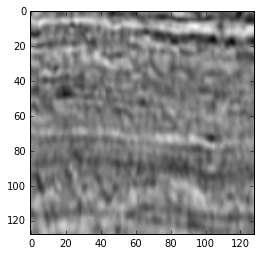

In [18]:
# it looks like train_gen generate ((train_image, feature), mask) * batch
tgt = 14

batch = train_gen.__next__()
plt.imshow(batch[0][0][tgt])

In [19]:
batch[0][1][tgt]

array([0.6327908], dtype=float32)

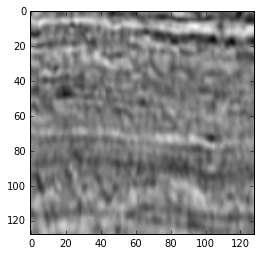

In [20]:
plt.imshow(batch[0][0][tgt])

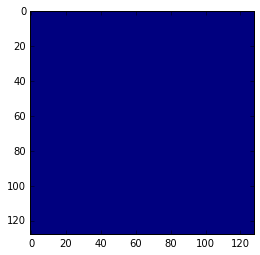

In [21]:
plt.imshow(np.squeeze(batch[1][tgt]))

In [22]:
train_gen

<generator object make_train_gen at 0x7fceb645bd58>

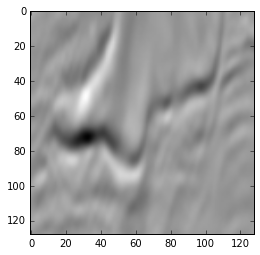

In [23]:
tgt = 40
plt.imshow(x_train[tgt])

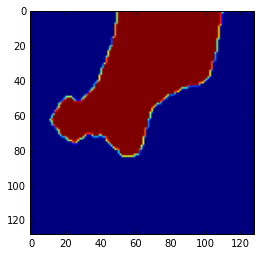

In [24]:
plt.imshow(np.squeeze(y_train[tgt]))

In [25]:
# seed = np.random.choice(range(9999))
# samplegen = ImageDataGenerator(rotation_range=180)
# gx = samplegen.flow(x_train[tgt].reshape(1, 128, 128, 3), batch_size=10, seed=seed)
# gy = samplegen.flow(y_train[tgt].reshape(1, 128, 128, 1), batch_size=10, seed=seed)
# batchx = gx.__next__()
# batchy = gy.__next__()
# plt.imshow(batchx[0])

In [26]:
# plt.imshow(np.squeeze(batchy[0]))

In [27]:
# unet_m.summary()

In [28]:
# unet_m = util.unet_model(min_filter_num=32)
unet_m = util.unet_model(min_filter_num=16, with_vec=True)
from keras.models import load_model
from keras.optimizers import Adam
# unet_m = load_model('./log/2018_0727_1808/best_weights.hdf5', custom_objects={'mean_iou': train_util.mean_iou})

In [29]:
# unet_m.summary()

In [ ]:
train_util.train(unet_m, train_gen, val_gen, loss=train_util.dice_p_bce, metrics=[train_util.dice_coef, 'binary_accuracy', train_util.true_positive_rate], epochs=3000, steps_per_epoch=32)
# rmsprop = keras.optimizers.RMSprop(lr=1e-4)
# train_util.train(unet_m, train_gen, val_gen, metrics=[train_util.mean_iou], epochs=3000, steps_per_epoch=32, optimizer=rmsprop)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_block_1 (Conv2D)        (None, 128, 128, 16) 448         input_layer[0][0]                
__________________________________________________________________________________________________
elu_1 (ELU)                     (None, 128, 128, 16) 0           encoder_block_1[0][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           elu_1[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (

Epoch 1/3000
 - 11s - loss: 1.4232 - dice_coef: 0.1778 - binary_accuracy: 0.7051 - true_positive_rate: 0.1114 - val_loss: 1.4007 - val_dice_coef: 0.1740 - val_binary_accuracy: 0.7365 - val_true_positive_rate: 0.0012
Finished epoch: 0
{'true_positive_rate': 0.1113850866931898, 'val_dice_coef': 0.17399587855700663, 'val_true_positive_rate': 0.0012278178472625233, 'val_binary_accuracy': 0.7364661996959108, 'val_loss': 1.4006716944564583, 'dice_coef': 0.17777284095063806, 'loss': 1.4232028126716614, 'binary_accuracy': 0.7050576210021973}

Epoch 00001: val_loss improved from inf to 1.40067, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 2/3000
 - 8s - loss: 1.4111 - dice_coef: 0.1598 - binary_accuracy: 0.7607 - true_positive_rate: 0.0074 - val_loss: 1.3969 - val_dice_coef: 0.1906 - val_binary_accuracy: 0.7371 - val_true_positive_rate: 0.0000e+00
Finished epoch: 1
{'true_positive_rate': 0.007430315055898973, 'val_dice_coef': 0.1905714543512364, 'lr': 0.001, 'val_true_positive_r

Epoch 14/3000
 - 8s - loss: 1.3717 - dice_coef: 0.1773 - binary_accuracy: 0.7659 - true_positive_rate: 1.1011e-04 - val_loss: 1.3382 - val_dice_coef: 0.2112 - val_binary_accuracy: 0.7371 - val_true_positive_rate: 3.7826e-06
Finished epoch: 13
{'true_positive_rate': 0.00011010873090810946, 'val_dice_coef': 0.21116857357074179, 'lr': 0.001, 'val_true_positive_rate': 3.782620953975346e-06, 'val_binary_accuracy': 0.7370913001136485, 'val_loss': 1.3381656383793887, 'dice_coef': 0.17731853108853102, 'loss': 1.371654860675335, 'binary_accuracy': 0.7658986449241638}

Epoch 00014: val_loss improved from 1.35980 to 1.33817, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 15/3000
 - 8s - loss: 1.3309 - dice_coef: 0.2162 - binary_accuracy: 0.7350 - true_positive_rate: 0.0148 - val_loss: 1.2826 - val_dice_coef: 0.2336 - val_binary_accuracy: 0.7363 - val_true_positive_rate: 0.0153
Finished epoch: 14
{'true_positive_rate': 0.01476273772186687, 'val_dice_coef': 0.23355388534099705, 'lr': 

Epoch 27/3000
 - 8s - loss: 1.2031 - dice_coef: 0.2559 - binary_accuracy: 0.7905 - true_positive_rate: 0.5984 - val_loss: 1.1441 - val_dice_coef: 0.3040 - val_binary_accuracy: 0.7848 - val_true_positive_rate: 0.6855
Finished epoch: 26
{'true_positive_rate': 0.5983676668256521, 'val_dice_coef': 0.3040213166594812, 'lr': 0.001, 'val_true_positive_rate': 0.6855094342427879, 'val_binary_accuracy': 0.7847936481314024, 'val_loss': 1.1441487064704796, 'dice_coef': 0.255887049715966, 'loss': 1.20313261449337, 'binary_accuracy': 0.7905316948890686}

Epoch 00027: val_loss improved from 1.15075 to 1.14415, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 28/3000
 - 8s - loss: 1.1858 - dice_coef: 0.2630 - binary_accuracy: 0.7948 - true_positive_rate: 0.6088 - val_loss: 1.1394 - val_dice_coef: 0.2890 - val_binary_accuracy: 0.8059 - val_true_positive_rate: 0.6068
Finished epoch: 27
{'true_positive_rate': 0.6088365353643894, 'val_dice_coef': 0.289010959756405, 'lr': 0.001, 'val_true_posit

Epoch 40/3000
 - 8s - loss: 1.1583 - dice_coef: 0.2871 - binary_accuracy: 0.7980 - true_positive_rate: 0.6188 - val_loss: 1.0906 - val_dice_coef: 0.3187 - val_binary_accuracy: 0.8097 - val_true_positive_rate: 0.6924
Finished epoch: 39
{'true_positive_rate': 0.6188361886888742, 'val_dice_coef': 0.31871574036872785, 'lr': 0.001, 'val_true_positive_rate': 0.6923721164541563, 'val_binary_accuracy': 0.8097237633555592, 'val_loss': 1.090625284570042, 'dice_coef': 0.28705501183867455, 'loss': 1.1582764480262995, 'binary_accuracy': 0.7979527711868286}

Epoch 00040: val_loss improved from 1.09363 to 1.09063, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 41/3000
 - 8s - loss: 1.1452 - dice_coef: 0.2788 - binary_accuracy: 0.8087 - true_positive_rate: 0.6222 - val_loss: 1.0871 - val_dice_coef: 0.3081 - val_binary_accuracy: 0.8239 - val_true_positive_rate: 0.6385
Finished epoch: 40
{'true_positive_rate': 0.6221544360741973, 'val_dice_coef': 0.3080996791317408, 'lr': 0.001, 'val_true_

Finished epoch: 52
{'true_positive_rate': 0.6265665721148252, 'val_dice_coef': 0.3234183782936675, 'lr': 0.001, 'val_true_positive_rate': 0.6812719903445795, 'val_binary_accuracy': 0.8259202031978912, 'val_loss': 1.0654854346976488, 'dice_coef': 0.2745509296655655, 'loss': 1.1335109490901232, 'binary_accuracy': 0.8231289982795715}

Epoch 00053: val_loss improved from 1.06818 to 1.06549, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 54/3000
 - 8s - loss: 1.1393 - dice_coef: 0.2774 - binary_accuracy: 0.8182 - true_positive_rate: 0.6214 - val_loss: 1.0659 - val_dice_coef: 0.3161 - val_binary_accuracy: 0.8331 - val_true_positive_rate: 0.6552
Finished epoch: 53
{'true_positive_rate': 0.6214377619326115, 'val_dice_coef': 0.31613310075970724, 'lr': 0.001, 'val_true_positive_rate': 0.6551843821849186, 'val_binary_accuracy': 0.8331454161813142, 'val_loss': 1.0658556584527377, 'dice_coef': 0.27738182758912444, 'loss': 1.1392669156193733, 'binary_accuracy': 0.8182306289672852}

Epo

 - 8s - loss: 1.1260 - dice_coef: 0.2800 - binary_accuracy: 0.8228 - true_positive_rate: 0.6475 - val_loss: 1.0495 - val_dice_coef: 0.3329 - val_binary_accuracy: 0.8295 - val_true_positive_rate: 0.7090
Finished epoch: 66
{'true_positive_rate': 0.6474513271823525, 'val_dice_coef': 0.33285907102427936, 'lr': 0.001, 'val_true_positive_rate': 0.7089539410828931, 'val_binary_accuracy': 0.8294919363024302, 'val_loss': 1.0494595042844053, 'dice_coef': 0.2799903564155102, 'loss': 1.1260347291827202, 'binary_accuracy': 0.8227548599243164}

Epoch 00067: val_loss improved from 1.05103 to 1.04946, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 68/3000
 - 8s - loss: 1.1389 - dice_coef: 0.2787 - binary_accuracy: 0.8215 - true_positive_rate: 0.6201 - val_loss: 1.0501 - val_dice_coef: 0.3272 - val_binary_accuracy: 0.8342 - val_true_positive_rate: 0.6984
Finished epoch: 67
{'true_positive_rate': 0.620081901550293, 'val_dice_coef': 0.32716885124809636, 'lr': 0.001, 'val_true_positive_rate'

Finished epoch: 79
{'true_positive_rate': 0.6214139834046364, 'val_dice_coef': 0.33422036411523204, 'lr': 0.001, 'val_true_positive_rate': 0.7129242907453013, 'val_binary_accuracy': 0.8354747935861425, 'val_loss': 1.0384693461396088, 'dice_coef': 0.28510851226747036, 'loss': 1.1234036590903997, 'binary_accuracy': 0.8244200944900513}

Epoch 00080: val_loss improved from 1.04197 to 1.03847, saving model to ./log/2018_0731_1659/best_weights.hdf5
Epoch 81/3000
 - 8s - loss: 1.1010 - dice_coef: 0.2915 - binary_accuracy: 0.8323 - true_positive_rate: 0.6426 - val_loss: 1.0499 - val_dice_coef: 0.3475 - val_binary_accuracy: 0.8192 - val_true_positive_rate: 0.7525
Finished epoch: 80
{'true_positive_rate': 0.6425505857914686, 'val_dice_coef': 0.34751110319000283, 'lr': 0.001, 'val_true_positive_rate': 0.7525475484852926, 'val_binary_accuracy': 0.8192154363678783, 'val_loss': 1.0499355238323653, 'dice_coef': 0.2914836476556957, 'loss': 1.1009845901280642, 'binary_accuracy': 0.8322502374649048}

Ep

Epoch 94/3000
 - 8s - loss: 1.1073 - dice_coef: 0.3144 - binary_accuracy: 0.8151 - true_positive_rate: 0.6489 - val_loss: 1.0395 - val_dice_coef: 0.3368 - val_binary_accuracy: 0.8347 - val_true_positive_rate: 0.7292
Finished epoch: 93
{'true_positive_rate': 0.648892811499536, 'val_dice_coef': 0.33681385452765733, 'lr': 0.001, 'val_true_positive_rate': 0.7291953886995586, 'val_binary_accuracy': 0.8347312322312578, 'val_loss': 1.0395052056079659, 'dice_coef': 0.3144303513690829, 'loss': 1.1072925552725792, 'binary_accuracy': 0.8151259422302246}

Epoch 00094: val_loss did not improve
Epoch 95/3000
 - 8s - loss: 1.1038 - dice_coef: 0.3013 - binary_accuracy: 0.8292 - true_positive_rate: 0.6360 - val_loss: 1.0381 - val_dice_coef: 0.3283 - val_binary_accuracy: 0.8434 - val_true_positive_rate: 0.6783
Finished epoch: 94
{'true_positive_rate': 0.6360148750245571, 'val_dice_coef': 0.3282913469103737, 'lr': 0.001, 'val_true_positive_rate': 0.6782731533356988, 'val_binary_accuracy': 0.8433768856494

 - 8s - loss: 1.0885 - dice_coef: 0.3069 - binary_accuracy: 0.8344 - true_positive_rate: 0.6460 - val_loss: 1.0336 - val_dice_coef: 0.3482 - val_binary_accuracy: 0.8323 - val_true_positive_rate: 0.7343
Finished epoch: 107
{'true_positive_rate': 0.6459683431312442, 'val_dice_coef': 0.3481743942496096, 'lr': 0.001, 'val_true_positive_rate': 0.7342515995386021, 'val_binary_accuracy': 0.8322752334158341, 'val_loss': 1.0336281972863068, 'dice_coef': 0.3068823218345642, 'loss': 1.0884575936943293, 'binary_accuracy': 0.8344345688819885}

Epoch 00108: val_loss did not improve
Epoch 109/3000
 - 8s - loss: 1.1085 - dice_coef: 0.3054 - binary_accuracy: 0.8228 - true_positive_rate: 0.6398 - val_loss: 1.0324 - val_dice_coef: 0.3426 - val_binary_accuracy: 0.8360 - val_true_positive_rate: 0.7252
Finished epoch: 108
{'true_positive_rate': 0.6397844748571515, 'val_dice_coef': 0.34255273789550467, 'lr': 0.001, 'val_true_positive_rate': 0.725221280726798, 'val_binary_accuracy': 0.8359938283812417, 'val_l

 - 8s - loss: 1.0992 - dice_coef: 0.3050 - binary_accuracy: 0.8287 - true_positive_rate: 0.6444 - val_loss: 1.0261 - val_dice_coef: 0.3408 - val_binary_accuracy: 0.8413 - val_true_positive_rate: 0.7152
Finished epoch: 121
{'true_positive_rate': 0.6444004941731691, 'val_dice_coef': 0.3408374809360749, 'lr': 0.001, 'val_true_positive_rate': 0.7152272047604264, 'val_binary_accuracy': 0.841315654218963, 'val_loss': 1.0260732783756403, 'dice_coef': 0.30501739401370287, 'loss': 1.0992329977452755, 'binary_accuracy': 0.8286951780319214}

Epoch 00122: val_loss did not improve
Epoch 123/3000
 - 8s - loss: 1.0819 - dice_coef: 0.2873 - binary_accuracy: 0.8455 - true_positive_rate: 0.6346 - val_loss: 1.0279 - val_dice_coef: 0.3464 - val_binary_accuracy: 0.8358 - val_true_positive_rate: 0.7213
Finished epoch: 122
{'true_positive_rate': 0.6346298549324274, 'val_dice_coef': 0.34640468116897544, 'lr': 0.001, 'val_true_positive_rate': 0.7213183172564274, 'val_binary_accuracy': 0.8358206076303301, 'val_

Epoch 136/3000
 - 8s - loss: 1.1120 - dice_coef: 0.2824 - binary_accuracy: 0.8350 - true_positive_rate: 0.6119 - val_loss: 1.0199 - val_dice_coef: 0.3398 - val_binary_accuracy: 0.8449 - val_true_positive_rate: 0.7067
Finished epoch: 135
{'true_positive_rate': 0.611948593519628, 'val_dice_coef': 0.3397724044660063, 'lr': 0.001, 'val_true_positive_rate': 0.706680176190668, 'val_binary_accuracy': 0.8449170422431436, 'val_loss': 1.0198692944484995, 'dice_coef': 0.28240161668509245, 'loss': 1.1119716055691242, 'binary_accuracy': 0.8349515199661255}

Epoch 00136: val_loss did not improve
Epoch 137/3000
 - 8s - loss: 1.0900 - dice_coef: 0.2998 - binary_accuracy: 0.8357 - true_positive_rate: 0.6433 - val_loss: 1.0216 - val_dice_coef: 0.3439 - val_binary_accuracy: 0.8403 - val_true_positive_rate: 0.7216
Finished epoch: 136
{'true_positive_rate': 0.643261956050992, 'val_dice_coef': 0.3438897587186573, 'lr': 0.001, 'val_true_positive_rate': 0.72161433782553, 'val_binary_accuracy': 0.8402537367950

 - 8s - loss: 1.0855 - dice_coef: 0.2948 - binary_accuracy: 0.8429 - true_positive_rate: 0.6418 - val_loss: 1.0159 - val_dice_coef: 0.3433 - val_binary_accuracy: 0.8458 - val_true_positive_rate: 0.7098
Finished epoch: 149
{'true_positive_rate': 0.6418128814548254, 'val_dice_coef': 0.3432840888788277, 'lr': 0.00020000001, 'val_true_positive_rate': 0.7097996307829045, 'val_binary_accuracy': 0.8457900489510485, 'val_loss': 1.0158829367252733, 'dice_coef': 0.2947752857580781, 'loss': 1.0854576546698809, 'binary_accuracy': 0.8429369330406189}

Epoch 00150: val_loss did not improve
Epoch 151/3000
 - 8s - loss: 1.0922 - dice_coef: 0.2941 - binary_accuracy: 0.8380 - true_positive_rate: 0.6521 - val_loss: 1.0155 - val_dice_coef: 0.3377 - val_binary_accuracy: 0.8496 - val_true_positive_rate: 0.6916
Finished epoch: 150
{'true_positive_rate': 0.6520904954522848, 'val_dice_coef': 0.3377114556595721, 'lr': 0.00020000001, 'val_true_positive_rate': 0.6916497055546483, 'val_binary_accuracy': 0.84964248

Finished epoch: 162
{'true_positive_rate': 0.6333791464567184, 'val_dice_coef': 0.3443434717262925, 'lr': 0.00020000001, 'val_true_positive_rate': 0.7135285379647596, 'val_binary_accuracy': 0.8448811118277915, 'val_loss': 1.0145612343724406, 'dice_coef': 0.3193610217422247, 'loss': 1.0749475564807653, 'binary_accuracy': 0.8338675498962402}

Epoch 00163: val_loss did not improve
Epoch 164/3000
 - 8s - loss: 1.0749 - dice_coef: 0.3102 - binary_accuracy: 0.8372 - true_positive_rate: 0.6478 - val_loss: 1.0153 - val_dice_coef: 0.3456 - val_binary_accuracy: 0.8443 - val_true_positive_rate: 0.7165
Finished epoch: 163
{'true_positive_rate': 0.6477770237252116, 'val_dice_coef': 0.345561789439699, 'lr': 0.00020000001, 'val_true_positive_rate': 0.7164833982376942, 'val_binary_accuracy': 0.8442503630655284, 'val_loss': 1.0152574878731853, 'dice_coef': 0.31016417127102613, 'loss': 1.0748769342899323, 'binary_accuracy': 0.8372102975845337}

Epoch 00164: val_loss did not improve
Epoch 165/3000
 - 8s 

 - 8s - loss: 1.0611 - dice_coef: 0.3183 - binary_accuracy: 0.8420 - true_positive_rate: 0.6490 - val_loss: 1.0137 - val_dice_coef: 0.3443 - val_binary_accuracy: 0.8456 - val_true_positive_rate: 0.7121
Finished epoch: 176
{'true_positive_rate': 0.6489965626969934, 'val_dice_coef': 0.344281107646947, 'lr': 4.0000003e-05, 'val_true_positive_rate': 0.7120540232462258, 'val_binary_accuracy': 0.845552027531945, 'val_loss': 1.0136773552563625, 'dice_coef': 0.31825065799057484, 'loss': 1.0611363649368286, 'binary_accuracy': 0.8420029878616333}

Epoch 00177: val_loss did not improve
Epoch 178/3000
 - 8s - loss: 1.0653 - dice_coef: 0.3230 - binary_accuracy: 0.8364 - true_positive_rate: 0.6524 - val_loss: 1.0146 - val_dice_coef: 0.3449 - val_binary_accuracy: 0.8447 - val_true_positive_rate: 0.7147
Finished epoch: 177
{'true_positive_rate': 0.652393571101129, 'val_dice_coef': 0.34490869360901705, 'lr': 4.0000003e-05, 'val_true_positive_rate': 0.7147488557281102, 'val_binary_accuracy': 0.844669136

In [ ]:
val_gen